In [2]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import pandas as pd
from cvxopt import matrix, solvers
np.set_printoptions(suppress=True)
solvers.options['show_progress'] = False

In [2]:
df = pd.read_csv('datasets/db_seno.csv')
df.head()

,C1,C2,C3,Clase
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [ ]:
# separar en variables dependientes e independiente
X = df.drop(columns = 'Clase')
y = df.Clase

In [164]:
class LogisticRegression(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, learning_rate = 0.001, max_iter = 10000, threshold = 0.5, tol = 1e-15, 
                 penalty = None, lam = None, gamma = None, random_state = None):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.threshold = threshold
        self.tol = tol
        self.penalty = penalty
        self.lam = lam
        self.gamma = gamma
        self.random_state = random_state

        
    def _add_bias(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))
    
    def _adapt_x_matrix(self, X):
        X = np.array(X)
        X = self._add_bias(X)
        return X
    
    def _adapt_y_matrix(self, y):
        return np.array(y)
    
    def _adapt_df_matrix(self, X, y):
        X = self._adapt_x_matrix(X)
        y = self._adapt_y_matrix(y)
        return X, y
    
    def _initialize_weights(self, input_size):
        np.random.seed(self.random_state)
        limit = np.sqrt(6 / (input_size + 1))
        return np.random.uniform(-limit, limit, size = (input_size,))
    
    def _hyperplane(self, X, w):
        return np.dot(X, w)
    
    def _sigmoid(self, X, w):
        return 1 / (1 + np.exp(-self._hyperplane(X, w)))
    
    def _get_penalties(self, penalty):
        penalties = {'l1': lambda n, w, lam, gamma: (lam / n) * np.sum(np.abs(w)),
                            'l2': lambda n, w, lam, gamma: (lam / n) * np.sum(w ** 2),
                            'elasticnet': lambda n, w, lam, gamma: gamma * (lam / n) * np.sum(np.abs(w)) +
                                                                (1 - gamma) * (lam / n) * np.sum(w ** 2),
                            None : lambda n, w, lam, gamma: 0}
        return penalties[penalty]
    
    def _loss_function(self, X, y, w, epsilon):
        sigmoid = np.clip(a = self._sigmoid(X, w), a_min = epsilon, a_max = 1 - epsilon)
        penalty_mode = self._get_penalties(self.penalty)(X.shape[0], w, self.lam, self.gamma)
        return (- 1 / X.shape[0]) * np.sum(y * np.log(sigmoid) + (1 - y) * np.log(1 - sigmoid)) + penalty_mode
    
    def _derivatives(self, X, y, w):
        y_pred = self._sigmoid(X, w)
        error = y - y_pred
        return (1 / X.shape[0]) * np.matmul(error, -X)
    
    def _change_parameters(self, w, derivatives, alpha):
        return w - alpha * derivatives
    
    def fit(self, X, y):
        # getting numpy arrays
        X, y = self._adapt_df_matrix(X, y)
        
        # initializing random weights
        self.weights = self._initialize_weights(X.shape[1])
        
        # iterations till converging
        for _ in range(self.max_iter):
            loss = self._loss_function(X, y, self.weights, self.tol)
            dw = self._derivatives(X, y, self.weights)
            self.weights = self._change_parameters(self.weights, dw, self.learning_rate)
            
        return self
    def transform(self, X, y = None):
        pass
    def predict(self, X, y = None):
        X = self._adapt_x_matrix(X)
        return (self._sigmoid(X, self.weights) > self.threshold) * 1
    
    def predict_proba(self, X, y = None):
        X = self._adapt_x_matrix(X)
        probabilities = self._sigmoid(X, self.weights)
        return np.column_stack([1 - probabilities, probabilities])
    
    def predict_log_proba(self, X, y = None):
        X = self._adapt_x_matrix(X)
        probabilities = self._sigmoid(X, self.weights)
        return np.column_stack([np.log(1 - probabilities), np.log(probabilities)])

In [ ]:
lr = LogisticRegression()
lr.fit(X, y)

In [ ]:
(lr.predict(X) == y).sum() / len(y)

In [ ]:
y_pred = lr.predict(X)
y_pred

In [148]:
np.random.seed(0)  # Para asegurarse de obtener los mismos datos aleatorios cada vez
num_muestras = 300
num_features = 4
data = np.random.rand(num_muestras, num_features)

# Crear un arreglo de etiquetas (clases) del 0 al 2 para las 300 muestras
etiquetas = np.random.randint(0, 3, size=num_muestras)

# Crear el DataFrame
df = pd.DataFrame(data, columns=['Feature1', 'Feature2', 'Feature3', 'Feature4'])
df['Clase'] = etiquetas

# separar en variables dependientes e independiente
X = df.drop(columns = 'Clase')
y = df.Clase
#y = np.where(y == 0, -1, y)
# Dividr la data en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 23)

# Escalar la data
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.astype('float')

In [167]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
ovo_clf = OneVsOneClassifier(SVC(probability = True))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SVC(probability=True))

In [168]:
ovo_clf.predict(X_test)

array([1., 0., 2., 2., 2., 2., 0., 2., 0., 0., 2., 1., 1., 2., 2., 2., 2.,
       2., 2., 1., 2., 2., 0., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       0., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 1., 2., 2., 0., 2., 0., 2., 2., 0., 2., 2., 2., 0.,
       2., 2., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 2., 0., 2.,
       1., 2., 1., 2., 2.])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(MinMaxScaler(), LogisticRegression())
pipe.fit(X, y)

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [175]:
# Feature extracted vector of butterfly images
df = pd.read_csv("datasets/final_images.csv")

# showing top fifth
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,target
0,0.376471,0.65098,0.450980,0.380392,0.701961,0.501961,0.478431,0.603922,0.584314,0.486275,...,0.431373,0.478431,0.470588,0.545098,0.615686,0.611765,0.529412,0.580392,0.580392,1
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,1.000000,1.00000,1.000000,0.643137,0.639216,0.647059,0.662745,0.658824,0.666667,0.996078,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
3,1.000000,1.00000,1.000000,0.996078,0.996078,0.996078,0.992157,0.992157,0.996078,0.996078,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
4,0.258824,0.40000,0.266667,0.156863,0.349020,0.200000,0.145098,0.352941,0.196078,0.086275,...,0.031373,0.160784,0.086275,0.113725,0.321569,0.215686,0.007843,0.117647,0.039216,1


In [176]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(columns = 'target').copy().to_numpy()
y = df.target.copy().to_numpy()

sss1 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.30, random_state = 10)
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.50, random_state = 10)

for train_index, valtest_index in sss1.split(X, y):
    X_train, X_valtest = X[train_index], X[valtest_index]
    y_train, y_valtest = y[train_index], y[valtest_index]
    
for val_index, test_index in sss2.split(X_valtest, y_valtest):
    X_val, X_test = X_valtest[val_index], X_valtest[test_index]
    y_val, y_test = y_valtest[val_index], y_valtest[test_index]

In [177]:
n_components_pca = 124

In [185]:
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, sigmoid_kernel, polynomial_kernel, laplacian_kernel
K_linear = linear_kernel(X = X_train)
K_rbf = rbf_kernel(X = X_train, gamma = 0.001)
K_sigmoid = sigmoid_kernel(X = X_train, gamma = 0.001, coef0 = 1)
K_polynomial = polynomial_kernel(X = X_train, degree = 3, gamma = 0.001, coef0 = 1)
K_laplacian = laplacian_kernel(X = X_train, gamma = 0.001)

In [180]:
K_linear.shape

(582, 582)

In [181]:
K_rbf.shape

(582, 582)

In [182]:
K_sigmoid.shape

(582, 582)

In [186]:
K_laplacian.shape

(582, 582)

In [227]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, sigmoid_kernel, polynomial_kernel, laplacian_kernel
from cvxopt import matrix, solvers
import numpy as np

solvers.options['show_progress'] = False

class SVC(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, kernel = 'rbf', C = 1.5, degree = 3, gamma = None, coef0 = 0.0, 
                 probability = False, random_state = None):
        self.kernel = kernel
        self.C = C
        self.degree = 3
        self.gamma = gamma
        self.coef0 = coef0
        self.probability = probability
        self.random_state = random_state
        
    def _init_X(self, X):
        return np.array(X, dtype = 'float')
    
    def _init_y(self, y):
        return np.where(y == 0, -1, y)
    
    def _initialize_weights(self, input_size):
        np.random.seed(self.random_state)
        limit = np.sqrt(6 / (input_size + 1))
        return np.random.uniform(-limit, limit, size = (input_size,))
    
    # Kernels to transform X matrix
    def _rbf_kernel(self, X, Y):
        return rbf_kernel(X = X, Y = Y, gamma = self.gamma)
    
    def _linear_kernel(self, X, Y):
        return linear_kernel(X = X, Y = Y)
    
    def _poly_kernel(self, X, Y):
        return polynomial_kernel(X = X, Y = Y, degree = self.degree, gamma = self.gamma, coef0 = self.coef0)
    
    def _sigmoid_kernel(self, X, Y):
        return sigmoid_kernel(X = X, Y = Y, gamma = self.gamma, coef0 = self.coef0)
    
    def _laplacian_kernel(self, X, Y):
        return laplacian_kernel(X = X, Y = Y, gamma = self.gamma)
        
    def _get_alphas(self, X, y, C):
        n, m = X.shape
        y = y.astype(float)
        K = getattr(self, f"_{self.kernel}_kernel")(X, X)
        P = matrix(C * np.outer(y,y) * K)
        if np.iscomplexobj(P):
            raise ValueError("Complex data not supported")
        q = matrix(-np.ones(n))
        if self.C is None:
            G = matrix(-np.eye(n))
            h = matrix(np.zeros(n))
        else:
            tmp1 = -np.eye(n)
            tmp2 = np.identity(n)
            G = matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n)
            tmp2 = np.ones(n) * C
            h = matrix(np.hstack((tmp1, tmp2)))
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        try:
            sol = solvers.qp(P, q, G, h, A, b)
        except Exception as e:
            print(e)
        alpha = np.array(sol['x'])
        return alpha.flatten(), K, sol
    
    def _get_bias(self, y, sv_alphas, sv_y, sv_K):
        return (y - np.matmul(sv_alphas * sv_y, sv_K)).mean()
    
    def fit(self, X, y):
        if len(X) == 0:
            raise ValueError('Array is empty')
        if np.iscomplexobj(X) or np.iscomplexobj(y):
            raise ValueError("Complex data not supported.")
            
        # init arrays
        self.X = self._init_X(X)
        self.y = self._init_y(y)
        try:
            # converge alphas and get K
            alphas, self.K, self.sol = self._get_alphas(self.X, self.y, self.C)
        except Exception as e:
            # if there's an error the kernel is changed to rbf
            print(f"Error kernel {self.kernel}", e)
            print("Changing kernel to rbf")
            self.kernel = 'rbf' 
            alphas, self.K, self.sol = self._get_alphas(self.X, self.y, self.C)  
        
        # get support vectors
        sv_index = np.where(alphas > 1e-5)
        self.sv_alphas = alphas[sv_index]
        self.sv_x = self.X[sv_index]
        self.sv_y = self.y[sv_index]
        self.sv_K = self.K[sv_index]
        
        # get bias
        self.b = self._get_bias(y, self.sv_alphas, self.sv_y, self.sv_K)
        
        return self
    
    def transform(self, X):
        pass
    
    def get_bias(self):
        return self.b
    
    def get_support_vectors(self):
        return self.sv_alphas, self.sv_x, self.sv_y, self.sv_K
    
    def get_opt_solution(self):
        return self.sol
    
    def predict(self, X):
        # obtaining K values for new inputs
        X_k = getattr(self, f"_{self.kernel}_kernel")(self.sv_x, X)
        
        # getting predictions with bias
        y_pred = self.b + np.matmul(self.sv_alphas * self.sv_y, X_k)
        
        # returning in terms of 1 and 0
        return np.select([y_pred >= 0, y_pred < 0], [1, 0])
    
    def predict_proba(self, X):
        if self.probability:
            # obtaining K values for new inputs
            X_k = getattr(self, f"_{self.kernel}_kernel")(self.sv_x, X)

            # Obtaining probabilities
            raw_scores = self.b + np.matmul(self.sv_alphas * self.sv_y, X_k)
            probabilities = 1 / (1 + np.exp(-raw_scores))

            # Returning negative and  positives proabilities
            return np.column_stack((1 - probabilities, probabilities))
        else:
            raise ValueError('You have to set Probability to True')
            
    def predict_log_proba(self, X):
        if self.probability:
            # obtaining K values for new inputs
            X_k = getattr(self, f"_{self.kernel}_kernel")(self.sv_x, X)

            # Obtaining probabilities
            raw_scores = self.b + np.matmul(self.sv_alphas * self.sv_y, X_k)
            probabilities = 1 / (1 + np.exp(-raw_scores))

            # Returning negative and  positives log_probabilities
            return np.column_stack((np.log(1 - probabilities), np.log(probabilities)))
        else:
            raise ValueError('You have to set Probability to True')

In [204]:
from sklearn.pipeline import make_pipeline

model_pip = SVC()
model_pip.fit(X_train, y_train)
y_pred_train = model_pip.predict(X_train)
y_pred_test = model_pip.predict(X_test)

In [205]:
y_pred_train

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,

In [234]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
X, y = make_circles(n_samples = 500, noise = 0.05, factor = 0.50, random_state = 42)
#y = np.where(y == 0, -1, y)
# Dividr la data en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 23)

# Escalar la data
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.astype('float')

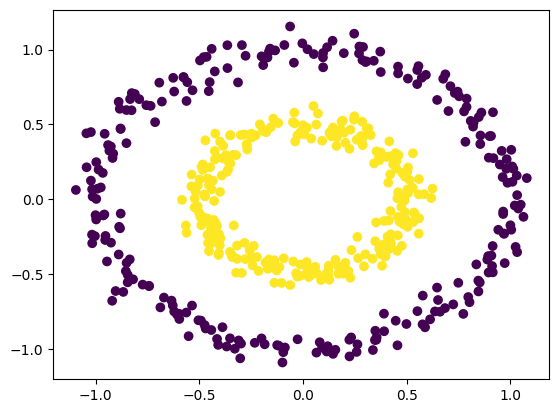

In [235]:
plt.scatter(x = X[:, 0], y = X[:, 1], c = y, cmap = 'viridis', marker = 'o', label = 'Data Points');

In [253]:
gamma_test = 1 / (X_train.shape[1] * X_train.var())
print(gamma_test)
svc = SVC(kernel = 'rbf', gamma = 10, probability = True)
svc.fit(X_train, y_train)
b = svc.get_bias()
sv_alphas, sv_x, sv_y, sv_K = svc.get_support_vectors()
y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)

7.4811664169400744


In [245]:
from sklearn.metrics import roc_auc_score
y_pred_test_proba = svc.predict_log_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_test_proba)

1.0

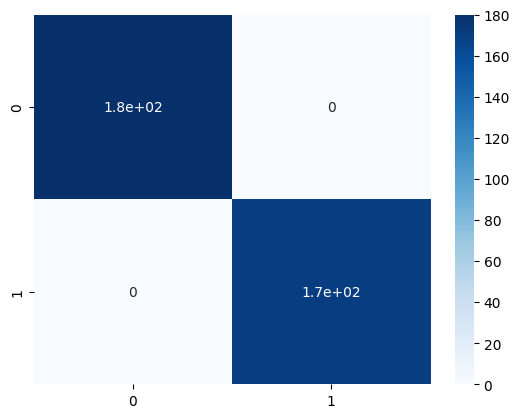

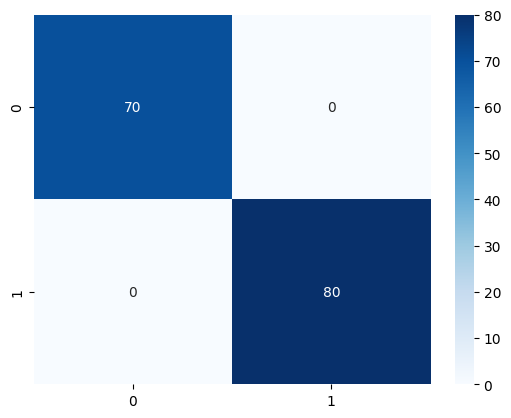

In [254]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot = True, cmap = 'Blues')
plt.show()
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True, cmap = 'Blues')
plt.show()

In [5]:
df = pd.read_csv('datasets/db_seno.csv')
df.head()

,C1,C2,C3,Clase
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [10]:
from scipy.spatial.distance import minkowski
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
X = df.drop(columns = 'Clase').copy().to_numpy()
y = df.Clase.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 23)

# Escalar la data
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
tree = KDTree(X_train)

In [96]:
[X_test[0]]

[array([0.80434783, 0.72727273, 0.        ])]

In [110]:
distances, k_indices = tree.query(X_test, k = 3)

In [99]:
k_indices

array([[117,   0,  40]], dtype=int64)

In [77]:
weights = 'uniform'
def _calculate_weights(distances, k_indices):
    if weights == 'uniform':
        return np.ones(len(k_indices))
    elif weights == 'distance':
        return 1 / (distances[k_indices] + 1e-6)
    elif callable(weights):
        return weights(distances[k_indices])

In [78]:
# Getting the closest k neighbors
k_nearest_labels = y_train[k_indices].copy()

# Calculating weights
weights_s = _calculate_weights(distances, k_indices)

# Getting the most common classes
most_common_votes = np.unique(k_nearest_labels, return_counts = True, axis = 0)

In [84]:
np.unique(k_nearest_labels, return_counts = True, axis = 1)

(array([[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1],
        [1, 1, 1],
        [0, 1, 1],
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 1, 1],
        [0, 1, 0],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 1],
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 0],
        [0, 1, 1],
        [0, 1, 0],
        [1, 0, 1],
        [1, 1, 1],
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 1],
        [1, 0, 1],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 0],
        [1, 0, 1],
        [1, 1, 1],
        [1, 1, 1],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 0],
        [1, 0, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 0, 0],
        [0, 1, 1],
        [1, 

In [76]:
distances[[0, 40 ,20]]

array([[0.        , 0.02173913, 0.04347826],
       [0.        , 0.02173913, 0.02173913],
       [0.        , 0.        , 0.02173913]])

In [64]:
distances

array([[0.        , 0.02173913, 0.04347826],
       [0.        , 0.06165219, 0.06521739],
       [0.        , 0.05804868, 0.0934722 ],
       [0.        , 0.06799361, 0.072241  ],
       [0.        , 0.02902434, 0.02902434],
       [0.        , 0.02173913, 0.06521739],
       [0.        , 0.08905762, 0.10258969],
       [0.        , 0.02902434, 0.04754137],
       [0.        , 0.09858069, 0.14752401],
       [0.        , 0.01923077, 0.03846154],
       [0.        , 0.02902434, 0.10984286],
       [0.        , 0.13184481, 0.17051117],
       [0.        , 0.11830917, 0.12588158],
       [0.        , 0.05804868, 0.11538462],
       [0.        , 0.08836017, 0.10786154],
       [0.        , 0.02173913, 0.02173913],
       [0.        , 0.072241  , 0.08695652],
       [0.        , 0.02173913, 0.04754137],
       [0.        , 0.06521739, 0.10984286],
       [0.        , 0.072241  , 0.13577529],
       [0.        , 0.        , 0.02173913],
       [0.        , 0.05769231, 0.072241  ],
       [0.

In [26]:
k_indices

array([[  0,  40,  20],
       [  1, 139, 200],
       [  2,  13, 151],
       [  3,  51,  85],
       [  4, 119,  25],
       [  5, 205,  33],
       [  6,   1, 105],
       [  7, 184, 115],
       [  8, 150, 112],
       [  9, 156, 191],
       [ 10, 158,  27],
       [ 11, 150,   8],
       [ 12, 153, 126],
       [ 13,   2,  74],
       [ 14,  64,  82],
       [ 15, 132, 149],
       [ 16, 123,  29],
       [ 17, 185, 202],
       [ 18, 104, 199],
       [ 19,  37, 100],
       [ 20, 138,  40],
       [ 21, 121,  78],
       [ 22, 191,   9],
       [ 23, 115,  64],
       [ 24, 100,  97],
       [ 25,   4, 119],
       [ 26, 168,  59],
       [ 27, 178,  10],
       [ 28,  31, 206],
       [ 29,  66, 200],
       [ 30, 193,  70],
       [ 31, 163,  28],
       [ 32, 181, 111],
       [ 33, 125, 144],
       [ 34, 167,  93],
       [ 35, 197, 195],
       [ 36,  45,  59],
       [ 37,  19, 100],
       [ 38,  27, 159],
       [ 39, 186,  94],
       [ 40, 138,  20],
       [ 41, 194

array([[  0,  40,  20, 138, 117],
       [  1, 139, 200,   6, 101],
       [  2,  13, 151, 142,  57],
       ...,
       [211, 145, 143,  56, 195],
       [212,  76,  48,  20, 138],
       [213, 179, 123,  16,  26]], dtype=int64)

In [ ]:
input_vector = X_test[0]

In [ ]:
minkowski(input_vector, X_train[0])

In [ ]:
def eucledian_distance(X1,X2):
    return np.sqrt(np.sum((X1 - X2) ** 2))

In [ ]:
distances = np.array([eucledian_distance(X_test[1], X_vector) for X_vector in X_train])

In [ ]:
k_index = np.argsort(distances)[:7]
k_labels = y_train[k_index]
k_labels

In [ ]:
weights = 1 / (distances[k_index] + 1e-6)
weights

In [ ]:
weighted_votes = Counter(k_labels).most_common()
result = max(weighted_votes, key = lambda item: np.sum(weights[k_labels == item[0]]))[0]
result

In [ ]:
k_labels

In [ ]:
weights[k_labels == weighted_votes[0][0]]

In [129]:
from sklearn.neighbors import KDTree, BallTree
from collections import Counter

class KNeighborsClassifier(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, n_neighbors = 5, weights = 'uniform', algorithm = 'auto', leaf_size = 30, p = 2,
                metric = 'minkwoski'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.p = p
        self.metric = metric
    
    def _init_matrix(self, X, y):
        return np.array(X), np.array(y)
    
    def _calculate_weights(self, distances):
        if self.weights == 'uniform':
            return np.ones(len(distances))
        elif self.weights == 'distance':
            return 1 / (distances + 1e-6)
        elif callable(self.weights):
            return self.weights(distances)
        
    def _get_distance(self, x1, x2, metric):
        if metric == 'minkwoski':
            return np.sum(np.abs(x1 - x2) ** self.p) ** (1 / self.p)
        elif metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif metric == 'euclidean':
            return np.sum(np.abs(x1 - x2) ** 2) ** 1 / 2
        elif callable(metric):
            return metric(new_vector,current_vector)
    
    def _get_data_structure(self, X):
        if self.algorithm == 'auto':
            if len(X) > 1000:
                tree = BallTree(X, leaf_size = self.leaf_size)
            else:
                tree = KDTree(X, leaf_size = self.leaf_size)
        elif self.algorithm == 'ball_tree':
            tree = BallTree(X, leaf_size = self.leaf_size)
        elif self.algorithm == 'kd_tree':
            tree = KDTree(X, leaf_size = self.leaf_size)
        elif self.algorithm == 'brute_force':
            tree = BallTree(X, leaf_size = 1)
        return tree
        
    def fit(self, X, y):
        # only storing de X and y values that are going to be compared
        # to new incoming data points
        self.X, self.y = self._init_matrix(X, y)
        self.tree = self._get_data_structure(self.X)
        return self
    
    def predict(self, X):
        # it does it for each testing vector de matrix has
        return np.array([self._predict_vector(X_vector) for X_vector in X])
    
    def _predict_vector(self, x):
        # Calculating distances for a vector to each point of the training set
        distances, k_indices = self.tree.query([x], self.n_neighbors)

        # Getting the closest k neighbors
        k_nearest_labels = self.y[k_indices[0]]

        # Calculating weights
        weights = self._calculate_weights(distances[0])

        # Getting the most common classes
        most_common_votes = Counter(k_nearest_labels).most_common()

        # Return the most common class for the vector based on weights
        return max(most_common_votes, key = lambda item: np.sum(weights[k_nearest_labels == item[0]]))[0]

In [132]:
weight_callable = lambda distances: 1 / (distances ** 2 + 1e-6)
knn_clf = KNeighborsClassifier(n_neighbors = 4, algorithm = 'ball_tree', weights = 'uniform')
knn_clf.fit(X_train, y_train)
y_pred_train = knn_clf.predict(X_train)
y_pred_test = knn_clf.predict(X_test)

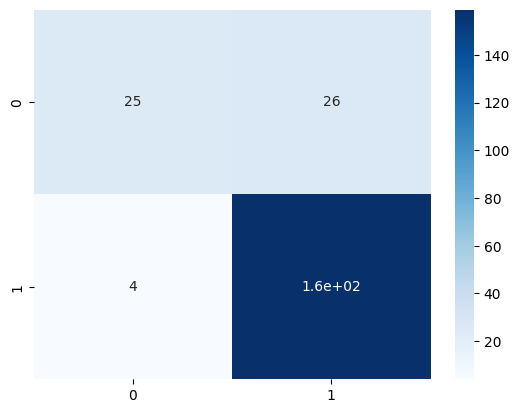

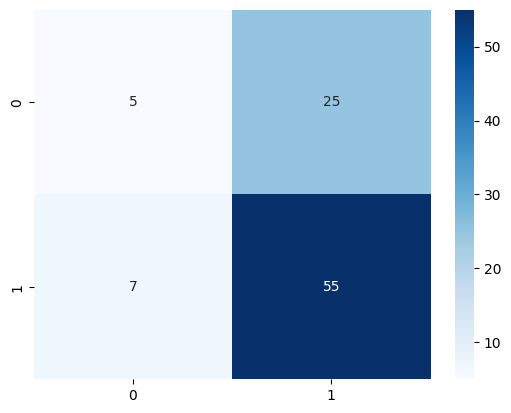

In [133]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot = True, cmap = 'Blues')
plt.show()
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True, cmap = 'Blues')
plt.show()

In [271]:
def print_tree(node, indent=""):
    if node is not None:
        print(indent + f"Depth {node.depth}:")
        if node.is_leaf():
            print(indent + f"Leaf Node - Predicted Label: {node.predicted_label}")
        else:
            print(indent + f"Internal Node - Feature: {node.feature}, Threshold: {node.threshold}")
            print_tree(node.left, indent + "  Left: ")
            print_tree(node.right, indent + "  Right: ")

# Llama a la función para imprimir el árbol
print_tree(tree.root) 

Depth 1:
Internal Node - Feature: 4, Threshold: 8.5
  Left: Depth 2:
  Left: Internal Node - Feature: 2, Threshold: 77.5
  Left:   Left: Depth 3:
  Left:   Left: Internal Node - Feature: 4, Threshold: 2.5
  Left:   Left:   Left: Depth 4:
  Left:   Left:   Left: Internal Node - Feature: 0, Threshold: 1.5
  Left:   Left:   Left:   Left: Depth 5:
  Left:   Left:   Left:   Left: Internal Node - Feature: 2, Threshold: 40.0
  Left:   Left:   Left:   Left:   Left: Depth None:
  Left:   Left:   Left:   Left:   Left: Leaf Node - Predicted Label: 1
  Left:   Left:   Left:   Left:   Right: Depth 6:
  Left:   Left:   Left:   Left:   Right: Internal Node - Feature: 2, Threshold: 43.5
  Left:   Left:   Left:   Left:   Right:   Left: Depth None:
  Left:   Left:   Left:   Left:   Right:   Left: Leaf Node - Predicted Label: 0
  Left:   Left:   Left:   Left:   Right:   Right: Depth None:
  Left:   Left:   Left:   Left:   Right:   Right: Leaf Node - Predicted Label: 1
  Left:   Left:   Left:   Right: Dep

In [255]:
import seaborn as sns
import numpy as np
import pandas as pd

iris = sns.load_dataset('iris')
display(iris.head())

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [257]:
from sklearn.model_selection import train_test_split

X = iris.drop(columns = 'species').copy().to_numpy()
y = iris.species.copy().to_numpy()
y = np.select([y == 'setosa', y == 'versicolor', y == 'virginica'],[0, 1, 2])
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.30, 
                                                    shuffle = True, random_state = 23)

In [258]:
class DecisionTreeClassifier(BaseEstimator, TransformerMixin, ClassifierMixin):
    class Node:
        '''
        feature = feature index which represents each column of numpy matrix
        threshold = value to be compared to new incoming data, this one could be a mean(numeric) or 1 (categoric)
        dtype_feature = data type of the feature
        partition_metric = gini or gain (entropy) which splitted the matrix
        n_samples = number of samples per partition in a node
        value = categoric list representation of value counts of classes, e.g [50, 60] for 0 and 1
        predicted_label = if the node is a leaf, this is the class it predicts
        left = left branch
        right = right branch
        depth = dpeth in which the node is located from root (depth = 0)
        '''
        def __init__(self, feature = None, threshold = None, dtype_feature = None ,
                     partition_metric = None, n_samples = None,
                    value = None, predicted_label = None, left = None, right = None, depth = None):
            self.feature = feature
            self.threshold = threshold
            self.dtype_feature = dtype_feature
            self.partition_metric = partition_metric
            self.n_samples = n_samples
            self.value = value
            self.predicted_label = predicted_label
            self.left = left
            self.right = right
            self.depth = depth

        def is_leaf(self):
            return self.left is None and self.right is None

        def is_internal(self):
            return not self.is_leaf()
        
    class Tree:
        def __init__(self, root_node):
            self.root = root_node

        def depth(self):
            return self._calculate_depth(self.root)

        def num_nodes(self):
            return self._count_nodes(self.root)

        def num_leaves(self):
            return self._count_leaves(self.root)

        def _calculate_depth(self, node):
            if node is None:
                return -1
            left_depth = self._calculate_depth(node.left)
            right_depth = self._calculate_depth(node.right)
            return max(left_depth, right_depth) + 1

        def _count_nodes(self, node):
            if node is None:
                return 0
            left_count = self._count_nodes(node.left)
            right_count = self._count_nodes(node.right)
            return left_count + right_count + 1

        def _count_leaves(self, node):
            if node is None:
                return 0
            if node.is_leaf():
                return 1
            left_leaves = self._count_leaves(node.left)
            right_leaves = self._count_leaves(node.right)
            return left_leaves + right_leaves
 
    def __init__(self, criterion = 'gini', max_depth = None, min_samples_split = 2,
                min_samples_leaf = 1, max_features = None, random_state = None, ccp_alpha = 0.0):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.ccp_alpha = ccp_alpha
    
    def _init_matrix(self, X, y):
        # converting into numpy arrays
        X, y = np.array(X), np.array(y)
        
        # concatenating for a while
        data = np.column_stack((X, y))

        # Finding unique indices based on X rows
        unique_indices = np.unique(data[:, :-1] , axis = 0, return_index = True)[1]

        # selecting X and y that are unique
        X = X[unique_indices]
        y = y[unique_indices]
        return X, y
    
    def _gini(self, y_target):
        target_distribution = np.unique(y_target, return_counts = True)[1] / len(y_target)
        return 1 - (target_distribution ** 2).sum()
    
    def _is_categoric(self, X_feature):
        return np.all((X_feature == 0) | (X_feature == 1))
    
    def _get_data_type(self, X):
        return {n_feature: 'cat' if self._is_categoric(X[:, n_feature]) else 'num'
               for n_feature in range(X.shape[1])}
    
    def _numeric_to_categoric(self, X_feature, mean_value):
        return (X_feature <= mean_value) * 1
    
    def _get_unique_values(self, y):
        return np.unique(y, return_counts = True)[1].tolist()
    
    def _generate_split_params(self, X_train, y_train):
        # According to max_features the model uses to split matrix
        num_features = int(X_train.shape[1])
        if self.max_features is None:
            max_features = num_features
        elif isinstance(self.max_features, int):
            max_features = min(self.max_features, num_features)
        elif isinstance(self.max_features, float):
            max_features = max(int(self.max_features * num_features), 1)
        else:
            raise ValueError("Invalid value for max_features")
        np.random.seed(self.random_state)
        selected_feature_indices = np.random.choice(num_features, max_features, replace = False)
        total_metrics = list()
        
        # Then we iterate across selected feature
        for n_feature in selected_feature_indices:
            X_feature = X_train[:, n_feature].copy()
            if self.data_types[n_feature] == 'cat':
                left_branch_y = y_train[X_feature == 1].copy()
                right_branch_y = y_train[X_feature == 0].copy()
                n_left = len(left_branch_y)
                n_right = len(right_branch_y)
                left_metric = self._gini(left_branch_y)
                right_metric = self._gini(right_branch_y)
                result_metric = (n_left / len(y_train)) * left_metric + (n_right / len(y_train)) * right_metric
                total_metrics.append((1, result_metric, n_feature, 'cat'))
            else:
                total_metric_num = list()
                sorted_indices = np.argsort(X_feature)
                X_feature_sorted = np.unique(X_feature[sorted_indices].copy())
                y_train_sorted = y_train[sorted_indices].copy()
                mean_values = np.unique((X_feature_sorted[:-1] + X_feature_sorted[1:]) / 2)
                # in case X_feature_sorted has one single value
                mean_values = mean_values if len(mean_values) != 0 else X_feature_sorted
                for mean_value in mean_values:
                    X_feature_cat = self._numeric_to_categoric(X_feature, mean_value)
                    left_branch_y = y_train[X_feature_cat == 1].copy()
                    right_branch_y = y_train[X_feature_cat == 0].copy()
                    n_left = len(left_branch_y)
                    n_right = len(right_branch_y)
                    left_metric = self._gini(left_branch_y)
                    right_metric = self._gini(right_branch_y)
                    result_metric = (n_left / len(y_train)) * left_metric + (n_right / len(y_train)) * right_metric
                    total_metric_num.append((mean_value, result_metric, n_feature, 'num'))
                total_metrics.append(min(total_metric_num, key = lambda x: x[1]))
        return min(total_metrics, key = lambda x: x[1])
    
    def _split_dataframe(self, X, y, split_threshold_value, n_feature, dtype_feature):
        X_splitted_left = X[X[:, n_feature] <= split_threshold_value].copy() if self.data_types[n_feature] == 'num' else X[X[:, n_feature] == 1].copy()
        y_splitted_left = y[X[:, n_feature] <= split_threshold_value].copy() if self.data_types[n_feature] == 'num' else y[X[:, n_feature] == 1].copy()

        X_splitted_right = X[X[:, n_feature] > split_threshold_value].copy() if self.data_types[n_feature] == 'num' else X[X[:, n_feature] == 0].copy()
        y_splitted_right = y[X[:, n_feature] > split_threshold_value].copy() if self.data_types[n_feature] == 'num' else y[X[:, n_feature] == 0].copy()

        return X_splitted_left, X_splitted_right, y_splitted_left, y_splitted_right
    
    def _build_tree(self, X, y, depth = 0, parent_node = None):
        
        # Establishing terminating terms
        #print('Vector y')
        #print(y)
        #print('shape')
        #print(y.shape)
        #print('Vector X')
        #print(X)
        #print('shape')
        #print(X.shape)
        #print('Unique values')
        #print(np.unique(y))
        if len(y) == 0:
            if parent_node is not None:
                return parent_node
            else:
                return self.Node(n_samples = len(y),
                                 partition_metric = 0,
                                 value = self._get_unique_values(y),
                                 predicted_label = Counter(y).most_common()[0][0])
        
        if self.max_depth is not None and depth >= self.max_depth:
            return self.Node(n_samples = len(y),
                             partition_metric = 0,
                             value = self._get_unique_values(y),
                             predicted_label = Counter(y).most_common()[0][0])
        
        if isinstance(self.min_samples_split, float):
            if self.min_samples_split <= 1.0:
                min_samples_split = max(int(np.ceil(self.min_samples_split * len(y))), 2)
            else:
                min_samples_split = max(int(self.min_samples_split), 2)
        else:
            min_samples_split = self.min_samples_split
        
        if isinstance(self.min_samples_leaf, float):
            min_samples_leaf = max(int(np.ceil(self.min_samples_leaf * len(y))), 1)
        else:
            min_samples_leaf = max(self.min_samples_leaf, 1)

        if len(y) < min_samples_split or len(y) < min_samples_leaf:
            return self.Node(n_samples = len(y),
                 partition_metric = 0,
                 value = self._get_unique_values(y),
                 predicted_label = Counter(y).most_common()[0][0])
    
        # Minimum terminating condition needed, among the above ones, otherwise the recursion'd blow up
        if len(np.unique(y)) == 1:
            return self.Node(n_samples = len(y),
                 partition_metric = 0,
                 value = self._get_unique_values(y),
                 predicted_label = Counter(y).most_common()[0][0])
        
        initial_impurity = self._gini(y)

        # Continue building the tree as before, but check ccp_alpha before splitting
        if self.ccp_alpha > 0.0 and initial_impurity  <= self.ccp_alpha:
            # If ccp_alpha is reached or exceeded, create a leaf node
            return self.Node(n_samples = len(y),
                             partition_metric = initial_impurity ,
                             value = self._get_unique_values(y),
                             predicted_label = Counter(y).most_common()[0][0])
        # Splitting Node into two
        split_threshold_value, metric_value, n_feature, dtype_feature = self._generate_split_params(X, y)
        X_splitted_left, X_splitted_right, y_splitted_left, y_splitted_right = self._split_dataframe(X, y, 
                                                                                          split_threshold_value,
                                                                                          n_feature,
                                                                                         dtype_feature)
        # Creating branches
        depth += 1
        left_subtree = self._build_tree(X_splitted_left, y_splitted_left, depth, parent_node = self.Node(feature = n_feature,
                                                                                                    threshold = split_threshold_value,
                                                                                                    dtype_feature = dtype_feature,
                                                                                                    partition_metric = metric_value,
                                                                                                    n_samples = len(y),
                                                                                                    value = self._get_unique_values(y),
                                                                                                    predicted_label = Counter(y).most_common()[0][0],
                                                                                                    left = None,
                                                                                                    right = None,
                                                                                                    depth = depth))
        
        right_subtree = self._build_tree(X_splitted_right, y_splitted_right, depth, parent_node = self.Node(feature = n_feature,
                                                                                                    threshold = split_threshold_value,
                                                                                                    dtype_feature = dtype_feature,
                                                                                                    partition_metric = metric_value,
                                                                                                    n_samples = len(y),
                                                                                                    value = self._get_unique_values(y),
                                                                                                    predicted_label = Counter(y).most_common()[0][0],
                                                                                                    left = None,
                                                                                                    right = None,
                                                                                                    depth = depth))
        

        # Creating new nodes
        return self.Node(feature = n_feature,
                        threshold = split_threshold_value,
                        dtype_feature = dtype_feature,
                        partition_metric = metric_value,
                        n_samples = len(y),
                        value = self._get_unique_values(y),
                        predicted_label = Counter(y).most_common()[0][0],
                        left = left_subtree,
                        right = right_subtree,
                        depth = depth)
    
    def fit(self, X, y):
        self.X , self.y = self._init_matrix(X, y)
        self.data_types = self._get_data_type(self.X)
        self.root_node = self._build_tree(self.X, self.y)
        return self
    
    def predict(self, X):
        # initilize an empty list that stores all predictions of X
        y_pred = []
        
        # iterating on each row of the X matrix
        for row in X:
            current_node = self.root_node
            while not (current_node.is_leaf() or current_node is None):
                feature_index = current_node.feature
                threshold = current_node.threshold
                dtype_feature = current_node.dtype_feature
                
                if dtype_feature == 'cat':
                    if row[feature_index] == threshold:
                        current_node = current_node.left
                    else:
                        current_node = current_node.right
                else:
                    if row[feature_index] <= threshold:
                        current_node = current_node.left
                    else:
                        current_node = current_node.right
            y_pred.append(current_node.predicted_label)
            
        return np.array(y_pred)
    
    @property
    def tree_(self):
        return self.Tree(self.root_node)

    @property
    def feature_importances_(self):
        if not hasattr(self, 'root_node'):
            raise ValueError("This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.")

        importances = np.zeros(self.X.shape[1])
        self._compute_feature_importances(self.root_node, importances)

        # Normalize the importances to sum up to 1
        importances /= importances.sum()

        return importances

    def _compute_feature_importances(self, node, importances):
        if node.is_internal():
            left_weight = node.left.n_samples / node.n_samples
            right_weight = node.right.n_samples / node.n_samples
            reduction = node.n_samples * node.partition_metric - (left_weight * node.left.n_samples * node.left.partition_metric + right_weight * node.right.n_samples * node.right.partition_metric)

            importances[node.feature] += reduction

        if node.left:
            self._compute_feature_importances(node.left, importances)
        if node.right:
            self._compute_feature_importances(node.right, importances)
            
    def cost_complexity_pruning_path(self, X, y, sample_weight=None):
        # Convert input to numpy arrays
        X , y = self._init_matrix(X, y)
        self.data_types = self._get_data_type(X)
        # Creating root node
        root_node = self._build_tree(X, y)
        
        # Initialize variables to store the pruning path
        ccp_alphas = []
        impurities = []
        
        # Calculate the initial impurity (before pruning)
        initial_impurity = self._gini(y)
        
        # Traverse the tree and compute pruning path
        self._compute_pruning_path(root_node, initial_impurity, ccp_alphas, impurities, X, y, sample_weight)
        
        return np.array(ccp_alphas), np.array(impurities)
    
    def _compute_pruning_path(self, node, impurity, ccp_alphas, impurities, X, y, sample_weight=None):
        if node.is_internal():
            left_weight = node.left.n_samples / node.n_samples
            right_weight = node.right.n_samples / node.n_samples
            reduction = node.n_samples * impurity - (left_weight * node.left.n_samples * node.left.partition_metric + right_weight * node.right.n_samples * node.right.partition_metric)

            if sample_weight is not None:
                reduction /= sum(sample_weight)

            alpha = reduction / (node.n_samples - 1)  # alpha is the cost-complexity factor

            # Check if alpha is greater than 0 (i.e., there's potential for pruning)
            if alpha > 0:
                ccp_alphas.append(alpha)
                impurities.append(impurity)

            # Continue with left and right subtrees
            self._compute_pruning_path(node.left, impurity, ccp_alphas, impurities, X, y, sample_weight)
            self._compute_pruning_path(node.right, impurity, ccp_alphas, impurities, X, y, sample_weight)

In [306]:
from scipy.spatial.distance import minkowski
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('datasets/db_seno.csv')
X = df.drop(columns = 'Clase').copy().to_numpy()
columna_binaria = np.random.randint(0, 2, size = len(X))
X = np.c_[columna_binaria, X]
columna_binaria = np.random.randint(0, 3, size = len(X))
X = np.c_[columna_binaria, X]
y = df.Clase.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 34)

# Escalar la data
#scaler = MinMaxScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [230]:
np.random.choice(5, 2, replace = False)

array([3, 0])

In [259]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [320]:
clf = DecisionTreeClassifier()
alphas, impurity = clf.cost_complexity_pruning_path(X_train, y_train)

In [326]:
clfs = []
alphas = np.sort(alphas)
for ccp_alpha in alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [316]:
tree = dt.tree_
tree.depth()

0

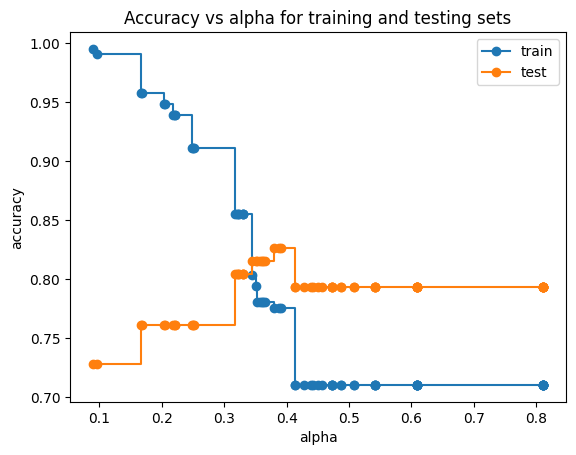

In [327]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [330]:
dt = DecisionTreeClassifier(random_state=0, ccp_alpha = 0.35)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.35, random_state=0)

In [331]:
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

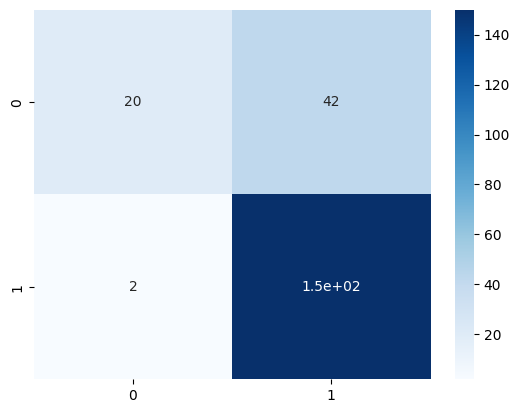

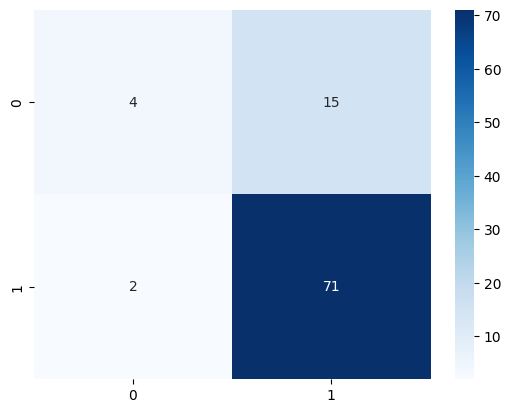

In [332]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot = True, cmap = 'Blues')
plt.show()
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True, cmap = 'Blues')
plt.show()

In [333]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(accuracy_score(y_train, y_pred_train))
print(recall_score(y_train, y_pred_train))
print(precision_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))
print(recall_score(y_test, y_pred_test))
print(precision_score(y_test, y_pred_test))

0.794392523364486
0.9868421052631579
0.78125
0.8152173913043478
0.9726027397260274
0.8255813953488372


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from cvxopt import matrix, solvers
import numpy as np

solvers.options['show_progress'] = False

class SVC(BaseEstimator, TransformerMixin, ClassifierMixin):
    def __init__(self, kernel = 'rbf', C = 1.5, degree = 3, gamma = 'scale', coef0 = 0.0, 
                 probability = False, random_state = None):
        self.kernel = kernel
        self.C = C
        self.degree = 3
        self.gamma = gamma
        self.coef0 = coef0
        self.probability = probability
        self.random_state = random_state
        
    def _init_X(self, X):
        return np.array(X, dtype = 'float')
    
    def _init_y(self, y):
        return np.where(y == 0, -1, y)
    
    def _initialize_weights(self, input_size):
        np.random.seed(self.random_state)
        limit = np.sqrt(6 / (input_size + 1))
        return np.random.uniform(-limit, limit, size = (input_size,))
    
    def _get_gamma(self, x, gamma):
        gamma_type = {'scale': lambda x: max(1.0 / (x.shape[1] * x.var()), 1e-3),
                            'auto': lambda x: 1.0 / x.shape[1]}
        
        return gamma_type[gamma](x) if isinstance(gamma, str) else gamma
    
    def _rbf_kernel(self, a, b):
        gamma = self._get_gamma(a, self.gamma)
        a = a.astype('float')
        b = b.astype('float')
        return np.exp(-(gamma / a.shape[1]) * np.sum((a - b[:, np.newaxis]) ** 2, axis = -1)).T
    
    def _linear_kernel(self, a, b):
        return np.dot(a, b.T)
    
    def _poly_kernel(self, a, b):
        return (np.dot(a, b.T) + self.coef0) ** self.degree
    
    def _sigmoid_kernel(self, a, b):
        gamma = self._get_gamma(a, self.gamma)
        return np.tanh(gamma * np.dot(a, b.T))
        
    def _get_alphas(self, X, y, C):
        n, m = X.shape
        y = y.astype(float)
        K = getattr(self, f"_{self.kernel}_kernel")(X, X)
        P = matrix(C * np.outer(y,y) * K)
        if np.iscomplexobj(P):
            raise ValueError("Complex data not supported")
        q = matrix(-np.ones(n))
        if self.C is None:
            G = matrix(-np.eye(n))
            h = matrix(np.zeros(n))
        else:
            tmp1 = -np.eye(n)
            tmp2 = np.identity(n)
            G = matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n)
            tmp2 = np.ones(n) * C
            h = matrix(np.hstack((tmp1, tmp2)))
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        try:
            sol = solvers.qp(P, q, G, h, A, b)
        except Exception as e:
            print(e)
        alpha = np.array(sol['x'])
        return alpha.flatten(), K, sol
    
    def _get_bias(self, y, sv_alphas, sv_y, sv_K):
        return (y - np.matmul(sv_alphas * sv_y, sv_K)).mean()
    
    def fit(self, X, y):
        if len(X) == 0:
            raise ValueError('Array is empty')
        if np.iscomplexobj(X) or np.iscomplexobj(y):
            raise ValueError("Complex data not supported.")
            
        # init arrays
        self.X = self._init_X(X)
        self.y = self._init_y(y)
        try:
            # converge alphas and get K
            alphas, self.K, self.sol = self._get_alphas(self.X, self.y, self.C)
        except Exception as e:
            # if theres an error the kernel is changed to rbf
            # y cambiar el kernel a uno más seguro, como RBF.
            print(f"Error kernel {self.kernel}", e)
            print("Changing kernel to rbf")
            self.kernel = 'rbf' 
            alphas, self.K, self.sol = self._get_alphas(self.X, self.y, self.C)  
        
        # get support vectors
        sv_index = np.where(alphas > 1e-5)
        self.sv_alphas = alphas[sv_index]
        self.sv_x = self.X[sv_index]
        self.sv_y = self.y[sv_index]
        self.sv_K = self.K[sv_index]
        
        # get bias
        self.b = self._get_bias(y, self.sv_alphas, self.sv_y, self.sv_K)
        
        return self
    
    def transform(self, X):
        pass
    
    def get_bias(self):
        return self.b
    
    def get_support_vectors(self):
        return self.sv_alphas, self.sv_x, self.sv_y, self.sv_K
    
    def get_opt_solution(self):
        return self.sol
    
    def predict(self, X):
        # obtaining K values for new inputs
        X_k = getattr(self, f"_{self.kernel}_kernel")(self.sv_x, X)
        
        # getting predictions with bias
        y_pred = self.b + np.matmul(self.sv_alphas * self.sv_y, X_k)
        
        # returning in terms of 1 and 0
        return np.select([y_pred >= 0, y_pred < 0], [1, 0])
    
    def predict_proba(self, X):
        if self.probability:
            # obtaining K values for new inputs
            X_k = getattr(self, f"_{self.kernel}_kernel")(self.sv_x, X)

            # Obtaining probabilities
            raw_scores = self.b + np.matmul(self.sv_alphas * self.sv_y, X_k)
            probabilities = 1 / (1 + np.exp(-raw_scores))

            # Returning negative and  positives proabilities
            return np.column_stack((1 - probabilities, probabilities))
        else:
            raise ValueError('You have to set Probability to True')
            
    def predict_log_proba(self, X):
        if self.probability:
            # obtaining K values for new inputs
            X_k = getattr(self, f"_{self.kernel}_kernel")(self.sv_x, X)

            # Obtaining probabilities
            raw_scores = self.b + np.matmul(self.sv_alphas * self.sv_y, X_k)
            probabilities = 1 / (1 + np.exp(-raw_scores))

            # Returning negative and  positives log_probabilities
            return np.column_stack((np.log(1 - probabilities), np.log(probabilities)))
        else:
            raise ValueError('You have to set Probability to True')